# Read large csv file and count occurances

CSV file is raw holdings file converted from SAS format

File must be transformed into parse matrix

# Import statements

In [1]:
import csv
import collections
import feather
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import sparse
import numpy as np

In [2]:
import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

from data.basic_functions import * 

# Find all unqiue Stocks and Portfolio/dates

In [3]:
def make_port_id(a,b):
    """
    Generate a unique ID from the portno and the date of a fund/date combination
    
    Input:
    - a: port_no
    - b: date
    
    Output:
    - port_ID
    """
    return int(100_000 * a + b)


In [8]:
# Simple version
def extra_reader(reader_object):
    """
    Loops over rows of holdings csv
    Nedded to generate sparse matrix
    
    Input: 
    - a reader object linking to the holdings csv
    
    Output: 
    - port_ID: Collection of all unique fund/date combinations
    - stock_ID: Collection of all unique stocks
    """
    
    next(reader)
    stocks = collections.Counter()
    port_ID = collections.Counter()
    
    for row in reader_object:
        port_ID_str = make_port_id(int(float(row[0])),int(float(row[1])))
        port_ID[port_ID_str] += 1
        stocks[int(float(row[7]))] += 1

    return(port_ID,stocks)  

In [9]:
path = '../data/raw/out.csv'

input_file = open(path)
reader = csv.reader(input_file, delimiter=',')

In [10]:
%%time
port_ID, stocks = extra_reader(reader)

CPU times: user 12min 43s, sys: 15.8 s, total: 12min 59s
Wall time: 13min 2s


In [11]:
sum(port_ID.values())

184578842

# Create stock and port_no map

In [12]:
def make_unique_dict(counter):
    """
    Used to make a dictionary linking each fund/date combination 
    and each stock to a row/col in the sparse matrix
    
    Input:
    - collections.Counter() object
    
    Output:
    - dictionary
    """
    
    unique_keys = list(counter.keys())
    unique_keys_numbers = list(np.arange(len(unique_keys)))
    counter_map = dict(zip(unique_keys, unique_keys_numbers))
    
    return(counter_map)

In [13]:
stock_map = make_unique_dict(stocks)
port_no_map = make_unique_dict(port_ID)

In [14]:
total_number_rows = sum(list(stocks.values()))
print('Total number of rows in file:  {:,}'.format(total_number_rows))
print('Numer of unique stocks:        {:,}'.format(len(stocks.keys())))
print('Numer of unique portfolios:    {:,}'.format(len(port_no_map.keys())))

Total number of rows in file:  184,578,842
Numer of unique stocks:        2,382,968
Numer of unique portfolios:    738,860


# Set up sparse matrix

In [15]:
def gen_sparse_data(reader):
    """
    Loop over holdings csv file to collect the data for the sparse matrix
    
    Input:
    - reader: CSV holdings file
    
    Output:
    - sparse_row, sparse_col, sparse_data: three np arrays for the construction of the sparse matrix
    """
    next(reader)
    
    counter = 0
    
    sparse_row = np.zeros(total_number_rows)
    sparse_col = np.zeros(total_number_rows)
    sparse_data = np.zeros(total_number_rows)
    
    for row in reader:
        # Row
        port_ID = make_port_id(int(float(row[0])),int(float(row[1])))
        sparse_row[counter] = port_no_map[port_ID]

        # Col
        stock_num = int(float(row[7]))
        sparse_col[counter] = stock_map[stock_num]

        # Data
        try:
            sparse_data[counter] = float(row[4])
        except: 
            sparse_data[counter] = 0
            
        counter += 1
    
    sparse_row = sparse_row.astype(int)
    sparse_col = sparse_col.astype(int)
    
    return(sparse_row, sparse_col, sparse_data)

In [16]:
path = '../data/raw/out.csv'
input_file = open(path)
reader = csv.reader(input_file, delimiter=',')

In [17]:
%%time
sparse_row, sparse_col, sparse_data = gen_sparse_data(reader)

CPU times: user 13min 38s, sys: 19.8 s, total: 13min 58s
Wall time: 14min 1s


# Check for duplicates and drop individual positions larger than 200

In [18]:
data = pd.DataFrame({'row': sparse_row, 'col' : sparse_col, 'data' :sparse_data})

In [19]:
data.shape

(184578842, 3)

### Fist mask: drop duplicates

In [20]:
mask1_duplicates = data.duplicated(subset=['row','col']) == False
data_s = data[mask1_duplicates]

### Second mask: Drop extrem individual values

In [21]:
# Drop observations where data is larger than 200 or smaller than -50 -> mask1
mask2_individual = (data_s['data'] < 150) & (data_s['data'] > -50)
data_s = data_s[mask2_individual]

In [22]:
sparse_row = data_s['row']
sparse_col = data_s['col']
sparse_data = data_s['data']

# Create sparse matrix

In [23]:
sparse_matrix = sparse.csr_matrix((sparse_data, (sparse_row, sparse_col)))
print('{:,}'.format(sparse_matrix.sum()))
sparse_matrix

70,398,705.39694649


<738860x2382968 sparse matrix of type '<class 'numpy.float64'>'
	with 177600020 stored elements in Compressed Sparse Row format>

### Third mask: drop extrem portfolios

In [24]:
### Drop portfolios with total percent_tna > 150 or < 150
row_sums = np.array(sparse_matrix.sum(1)).flatten()
mask3_portfolios = (row_sums < 150) & (row_sums > -50)
np.sum(mask3_portfolios)

733743

In [25]:
sparse_matrix = sparse_matrix[mask3_portfolios]
sparse_matrix

<733743x2382968 sparse matrix of type '<class 'numpy.float64'>'
	with 148778258 stored elements in Compressed Sparse Row format>

# Create sparse info df with Fund_portno and date for every row of the sparse matrix

In [26]:
def split_port_id(num):
    start1 = int(np.floor(num / 100_000))
    start2 = num - start1 * 100_000
    return(start1,start2)

In [27]:
%%time
port_no = []
date = []
keys = list(port_no_map.keys())

for port_IDs in keys:
    left_temp, right_temp = split_port_id(port_IDs)
    port_no.append(left_temp)
    date.append(right_temp)
    
date = pd.to_timedelta(date, unit='D') + pd.Timestamp('1960-1-1')

CPU times: user 2.81 s, sys: 239 ms, total: 3.05 s
Wall time: 3.3 s


In [28]:
sparse_info = pd.DataFrame(data={'port_no':port_no, 'date':date})

In [29]:
sparse_info = sparse_info[mask3_portfolios]

#### Check if dimensions match

In [30]:
sparse_info.shape

(733743, 2)

In [31]:
sparse_matrix.shape

(733743, 2382968)

# Save data

In [32]:
path = '../data/interim/stock_map_t'
stock_map_item = {'item1' : stock_map}
np.save(path,stock_map_item) 

#### Sparse matrix

In [33]:
path = '../data/interim/sparse_matrix_t'
sparse.save_npz(path, sparse_matrix)

#### Sparse info

In [34]:
path = '../data/interim/sparse_info_t.feather'
feather.write_dataframe(sparse_info,path)

### Try to calculate more percent_tna values
Not really succesfull
Look for another method or just kill all these values

In [ ]:
# Calc tna based on percent_tna and market value
holdings['calc_tna'] = holdings['market_val'] / holdings['percent_tna']

# replace inf in calc_tna with nan (caused by percent_tna = 0)
holdings['calc_tna'] = holdings['calc_tna'].replace([np.inf, -np.inf], np.nan)

In [ ]:
# Calc mean calc_tna per fund/date pair
holdings_mean = holdings.groupby(['crsp_portno', 'report_dt'])[['calc_tna']].agg('mean')

# Merge mean calc_tna back into holdings table
holdings_mean = holdings_mean.reset_index()
holdings = holdings.merge(holdings_mean,how='left',on=['crsp_portno', 'report_dt'])

In [ ]:
# Calc calc_percent_tna 
holdings['calc_percent_tna'] = holdings['market_val'] / holdings['calc_tna_y']

In [ ]:
holdings.loc[holdings['percent_tna'].notnull(),'calc_percent_tna'] = holdings['percent_tna']

In [ ]:
holdings.sample(5)

In [ ]:
# Show all for which percent_tna = NaN
holdings[np.isnan(holdings['calc_percent_tna'])].sample(100)

In [ ]:
# Nans per col
holdings.isnull().sum(axis=0)

# Analysis

### Data itself

In [ ]:
plt.plot(sparse_data)

In [ ]:
data_s.sort_values(by='data').reset_index()[['data']].plot()

### Row na dcolum sums

In [35]:
sparse_matrix.shape

(733743, 2382968)

In [36]:
row_sums = sparse_matrix.sum(1)
col_sums = sparse_matrix.sum(0)

In [37]:
row_sums = pd.DataFrame(row_sums)
col_sums = pd.DataFrame(col_sums).T

In [38]:
row_sums.describe()

,0
count,733743.000000
mean,94.439924
std,20.412875
min,-49.980010
25%,98.989971
50%,99.979967
75%,100.029984
max,149.989972


In [39]:
col_sums.describe()

,0
count,2.382968e+06
mean,2.907913e+01
std,8.784646e+02
min,-1.288807e+04
25%,0.000000e+00
50%,2.999999e-02
75%,8.499999e-01
max,3.983851e+05


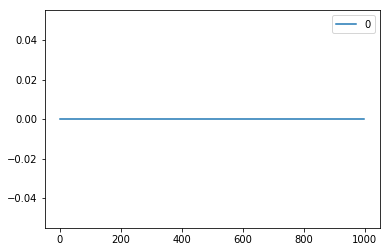

In [40]:
pd.DataFrame(sparse_matrix[35406,0:1000].todense()).T.plot()

## Sum of percent_tna per Fund/Date

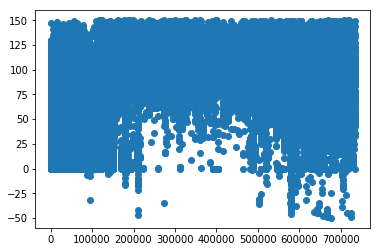

In [41]:
plt.plot(row_sums,'o')

## Observations per Stock

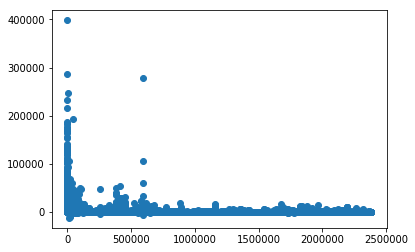

In [42]:
plt.plot(col_sums,'o')

### sparse_info

In [76]:
sparse_info.sample(5)

,port_no
date,
2012-12-31,1025688
2016-12-31,1031195
2013-09-30,1031460
2016-03-31,1023704
2016-06-30,1031820


### Reporting dates per port_no

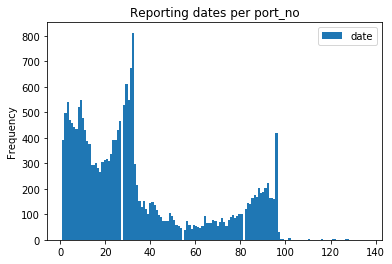

In [46]:
sparse_info.groupby('port_no').count().plot(kind='hist', bins=140, title= 'Reporting dates per port_no')

In [48]:
sparse_info = sparse_info.set_index('date')

### Observations per quarter

In [78]:
sparse_info.groupby([sparse_info.index.year,sparse_info.index.quarter]).count().head()

port_no
date date         
1960 1           1
2001 4           1
2002 2          12
     3          70
     4        1106

### Histogram of observations per Fund per Year
Most have two or more

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118a484a8>]],
      dtype=object)

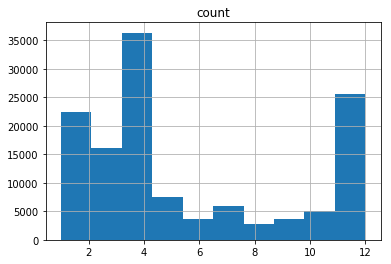

In [83]:
sparse_info['count'] = 1
sparse_info.groupby(['port_no',sparse_info.index.year]).count().hist()